In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import datetime

#### Create train and test transformer for image preprocessing

In [2]:
train_transformer = transforms.Compose([transforms.RandomRotation(45),
                                                    transforms.RandomHorizontalFlip(p = 0.4),
                                                    transforms.ColorJitter(brightness = 0.5, contrast = 0.5, hue = 0.3, saturation = 1.5),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])

In [3]:
# Download training data
train_data = torchvision.datasets.CIFAR10(root = '.',
                                          download = True,
                                          train = True,
                                          transform = transforms.ToTensor()   
                                         )

Files already downloaded and verified


In [4]:
test_data = torchvision.datasets.CIFAR10(root = '.',
                                         download = True,
                                         train = False,
                                         transform = transforms.ToTensor()
                                        )

Files already downloaded and verified


In [5]:
train_data.data[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [6]:
train_data.data.shape

(50000, 32, 32, 3)

In [7]:
# Number of classes
K = len(set(train_data.targets))
K

10

In [8]:
test_data.data.shape

(10000, 32, 32, 3)

In [9]:
# Data Loader

batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True
                                          )

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = False
                                         )

In [10]:
for inputs, targets in train_loader:
    break

In [11]:
inputs.shape

torch.Size([128, 3, 32, 32])

### Define the CNN model

This model used as a presentation doesn't have complex architecture because I tried stacking more layers but it takes like forever to finish training on my laptop...

In [12]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride =2),
            nn.ReLU()
        )
        
        self.dense_layers = nn.Sequential(
            nn.Dropout(p = 0.2),
            nn.Linear(in_features = 128*3*3, out_features = 1024),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(in_features = 1024, out_features = K)
        )
        
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.shape[0], -1)
        out = self.dense_layers(out)
        return out

In [13]:
# Instantiate model
model = CNN(K)

In [14]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
# Define a loop function 
def batch_gd(train_loader, test_loader, criterion, optimizer, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    # Traning loop
    for i in range(epochs):
        train_loss = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
        train_loss = np.mean(train_loss)
        train_losses[i] = train_loss
      
        test_loss = []
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)
        test_losses[i] = test_loss
        
        print(f'Epoch: {i+1}/{epochs}, train_loss: {train_loss: .3f}, test_loss:{test_loss: .3f}')
    return train_losses, test_losses

In [16]:
epochs = 8

train_losses, test_losses = batch_gd(train_loader, test_loader, criterion, optimizer, epochs)

Epoch: 1/8, train_loss:  1.372, test_loss: 1.188
Epoch: 2/8, train_loss:  1.021, test_loss: 1.020
Epoch: 3/8, train_loss:  0.856, test_loss: 0.948
Epoch: 4/8, train_loss:  0.726, test_loss: 0.897
Epoch: 5/8, train_loss:  0.624, test_loss: 0.927
Epoch: 6/8, train_loss:  0.535, test_loss: 0.917
Epoch: 7/8, train_loss:  0.450, test_loss: 0.961
Epoch: 8/8, train_loss:  0.386, test_loss: 0.985


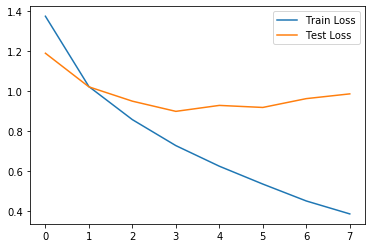

In [17]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.show()

Ater 5 epochs of training, even though the training loss is still reducing, there is some effect of overfitting showing on the validation test set. So it would be enough to stop training at epoch 5 or 6.

In [18]:
# Accuracy

n_correct = 0
n_total = 0

for inputs, targets in train_loader:
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    correct = (predictions == targets).sum()
    n_correct += correct.item()
    
    n_total += len(targets)
    
train_accuracy = n_correct/n_total
print('train_accuracy: %s' % (train_accuracy))

for inputs, targets in test_loader:
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    correct = (predictions == targets).sum()
    n_correct += correct.item()
    n_total += len(targets)
    
test_accuracy = n_correct/n_total

print('test_accuracy: %s' % (test_accuracy))

train_accuracy: 0.8981
test_accuracy: 0.8651666666666666


In [19]:
from sklearn.metrics import confusion_matrix
import itertools

x_test = test_data.data
y_test = test_data.targets
p_test = np.array([])

for inputs, targets in test_loader:
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.numpy()))


In [36]:
# label mapping
labels = '''airplane
    automobile
    bird
    cat
    deer
    dog
    frog
    horse
    ship
    truck'''.split()

In [39]:
# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize = False, cmap = plt.cm.Blues, title = 'Confusion matirx'):
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt), color = 'orange' if cm[i, j] > thresh else 'black',
                 horizontalalignment = 'center')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Prediction label')
    plt.show()

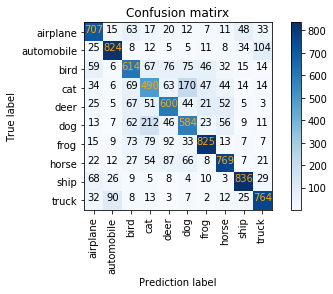

In [40]:
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, labels)

According to the confusion matrix, it can be referred that the model performs better on classifing automobile, frog and ship than other objects.

#### Show some misclassified examples

5106
actual label: frog
predicted label: bird


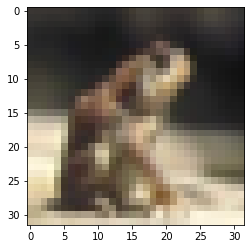

In [33]:
p_test = p_test.astype(np.uint8)
misclassified_id = np.where(p_test != y_test)[0]
im_id = np.random.choice(misclassified_id)
print(im_id)
plt.imshow(x_test[im_id].reshape(32, 32, 3))
print('actual label: %s' % (labels[y_test[im_id]]))
print('predicted label: %s' % (labels[p_test[im_id]]))

In [24]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             896
              ReLU-2           [-1, 32, 15, 15]               0
       BatchNorm2d-3           [-1, 32, 15, 15]              64
            Conv2d-4             [-1, 64, 7, 7]          18,496
              ReLU-5             [-1, 64, 7, 7]               0
       BatchNorm2d-6             [-1, 64, 7, 7]             128
            Conv2d-7            [-1, 128, 3, 3]          73,856
              ReLU-8            [-1, 128, 3, 3]               0
           Dropout-9                 [-1, 1152]               0
           Linear-10                 [-1, 1024]       1,180,672
             ReLU-11                 [-1, 1024]               0
          Dropout-12                 [-1, 1024]               0
           Linear-13                   [-1, 10]          10,250
Total params: 1,284,362
Trainable param